In [1]:
# Import all necessary libraries for the task

import re
import string
import torch
import numpy as np
import pandas as pd
import nltk
import emoji

import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn

import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from wordcloud import WordCloud, STOPWORDS

import transformers
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoModel
from transformers import Trainer, TrainingArguments
from transformers import AdamW
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from nltk.corpus import stopwords
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split

#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

from transformers import BertTokenizerFast
from transformers import TFBertModel, TFAutoModelForSequenceClassification
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
df_train = pd.read_csv('/kaggle/input/input-data/HODI_2023_train_subtaskA.tsv', sep='\t')
df_test = pd.read_csv('/kaggle/input/input-data/HODI_2023_test_subtaskA.csv', sep='\t')

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               5000 non-null   int64 
 1   text             5000 non-null   object
 2   homotransphobic  5000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 117.3+ KB


In [5]:
df_train.head()

,id,text,homotransphobic
0,1,Hanno rotto le #palle con i €compleanni a #dop...,0
1,2,"@user_abc Avete rotto,come potete prendere se ...",0
2,3,Guevara si è rotto il cazzo e ha mandato a far...,0
3,4,@user_abcd Se io volessi entrare in un bar con...,0
4,5,@user_abcdef @user_abc @user_abcdefgh Ok nessu...,0


In [7]:
pd.set_option('display.max_colwidth', None)

random_examples_label_0 = df_train[df_train['homotransphobic'] == 0].sample(5)

# Get 5 random examples with label 1
random_examples_label_1 = df_train[df_train['homotransphobic'] == 1].sample(5)

# Concatenate the two sets of examples
random_examples = pd.concat([random_examples_label_0, random_examples_label_1])

# Display the resulting DataFrame
random_examples

,id,text,homotransphobic
68,69,"Hai perso almeno 30min in attesa. Gli hai cmq dato i soldi Domani probabilmente richiederà ai clienti di indossarla. E stai fomentando la guerra social mask vs nomask che ha rotto le palle. Potevi mandarla a fare in culo, cambiare farma e tenertelo per te. Sono scelte. [URL]",0
2720,2721,spero che i piccioni del duomo ti attacchino e caghino addosso &lt;3 [URL],0
4386,4387,"@user_abcdef @user_abcdefghij @user_abcdefg Ma la foto di @user_ è fakata perché dalla vita in giù, il corpo è di donna: cosce, ginocchia gambe. Non è lui! O, allora è strano che sia così effeminato!",0
755,756,@user_abcd @user_abcdefghij Checca tu si bell pur co bicipit grange quanto la testa di genny,0
280,281,"sta roba che siccome in italia c'abbiamo il canto lirico e allora bisogna metterlo dappertutto ha rotto il cazzo, c'hanno il canto lirico anche su plutone tra un po', non mi pare caghino il cazzo così #Eurovision2022",0
1077,1078,È amore. A questo punto dovremmo chiederci chi è il piglianculo o mettinculo. [URL],1
2410,2411,Vada a farsi fottere sto coglione rotto in culo [URL],1
2528,2529,mi correggo Checca Peone c'è già...,1
104,105,@user_ab @user_abcde @user_abcdef @user_a Sono tutti innamorati del busone,1
2237,2238,@user_abcd Questo non è gay… è proprio ricchione! 🤮🤮🤮🤮,1


In [ ]:
df_test.info()
df_train.info()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


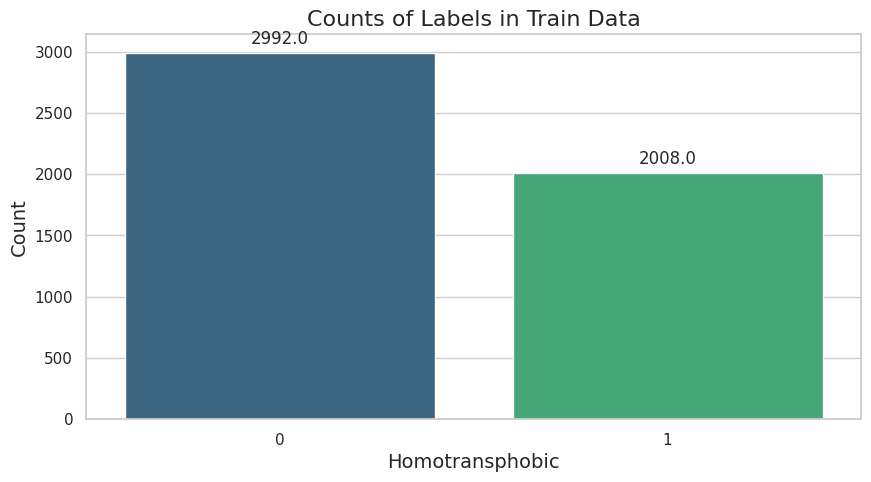

In [9]:
sns.set(style="whitegrid")

# Plotting the counts of labels
plt.figure(figsize=(10, 5))
ax = sns.countplot(x="homotransphobic", data=df_train, palette="viridis")

# Set plot title and labels
plt.title('Counts of Labels in Train Data', fontsize=16)
plt.xlabel('Homotransphobic', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Display the count values on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12)

# Show the plot
plt.show()

In [10]:
def pre_process(text): 
    text = text.lower() 
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) 
    text = re.sub(r"@\w+", "", text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('#', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('RT|rt', '', text)
    text = text.strip()
    return text

In [11]:
df_train["text"] = df_train["text"].apply(pre_process)
df_test["text"] = df_test["text"].apply(pre_process)

In [12]:
# Get Italian stopwords from nltk
italian_stopwords = set(stopwords.words('italian'))
# Add specific stopwords to the set
italian_stopwords.update(["RT", "rt", "URL", "fare", "solo", "fa"])

# Join all the text data in the selected rows where "homotransphobic" is 1
text_to_generate_wordcloud = " ".join(df_train.loc[df_train["homotransphobic"] == 1]["text"])

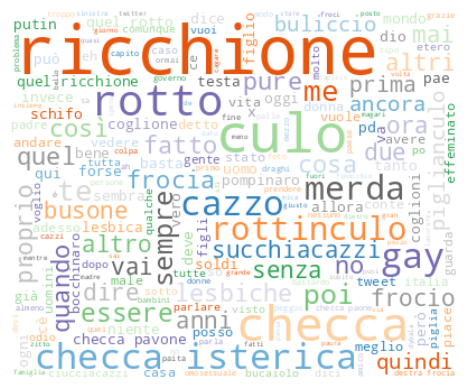

In [13]:
wordcloud = WordCloud(
    background_color='white',
    stopwords=italian_stopwords,
    width=400,
    height=330,
    colormap='tab20c',
    collocations=True,
    max_words=200,
    max_font_size=60,
    random_state=42
).generate(text_to_generate_wordcloud)

fig = plt.figure(1)
plt.imshow(wordcloud.recolor(random_state=3), interpolation="bilinear")
plt.axis('off')

plt.savefig("wordcloud_train_data.png")

plt.show()

In [14]:
from prettytable import PrettyTable

frequent_words = wordcloud.words_

# Sort the dictionary by frequency in descending order
sorted_frequent_words = sorted(frequent_words.items(), key=lambda x: x[1], reverse=True)

# Create a PrettyTable
table = PrettyTable(['Word', 'Frequency'])
for word, frequency in sorted_frequent_words:
    table.add_row([word, frequency])

# Set the table alignment
table.align['Word'] = 'l'
table.align['Frequency'] = 'r'

# Print the table
print(table)

+-----------------+----------------------+
| Word            |            Frequency |
+-----------------+----------------------+
| ricchione       |                  1.0 |
| culo            |   0.6377358490566037 |
| checca          |   0.4830188679245283 |
| rotto           |   0.4018867924528302 |
| gay             |  0.26037735849056604 |
| checca isterica |  0.25849056603773585 |
| cazzo           |  0.24339622641509434 |
| merda           |   0.2320754716981132 |
| rottinculo      |  0.21509433962264152 |
| me              |  0.17547169811320754 |
| te              |  0.16981132075471697 |
| poi             |  0.15283018867924528 |
| sempre          |  0.14150943396226415 |
| essere          |   0.1320754716981132 |
| no              |  0.12264150943396226 |
| cosa            |  0.12075471698113208 |
| quando          |  0.11886792452830189 |
| quel            |  0.11509433962264151 |
| così            |  0.11132075471698114 |
| fatto           |  0.10943396226415095 |
| pure     

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


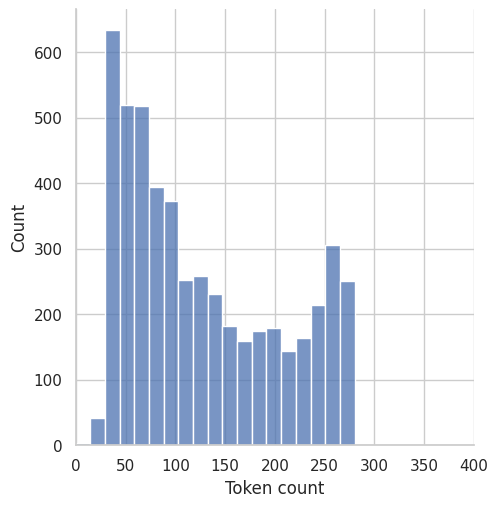

In [15]:
token_lens = []

for txt in df_train.text:
  token_lens.append(len(txt))

sns.displot(token_lens)
plt.xlim([0, 400]);
plt.xlabel('Token count');

In [16]:
X = df_train["text"].values
y = df_train["homotransphobic"].values

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=48)

In [19]:
X_test = df_test['text'].values

In [20]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape, X_test.shape

((4500,), (500,), (4500,), (500,), (1000,))

In [21]:
# Naive Bayes Classifier

clf = CountVectorizer() # transform a given text into a vector on the basis of the frequency (count) of each word 
X_train_cv = clf.fit_transform(X_train) # resulting X_train_cv is a sparse matrix where each row represents a document, 
                                        # and each column represents a unique word in the entire corpus

In [22]:
# We create TF-IDF of tokenized tweets

tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv) #TF-IDF on sparse matrix - see which words are relevant
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(clf.transform(X_test))

In [23]:
# Fitting Naive Bayes classifier

nb_clf = MultinomialNB()

nb_clf.fit(X_train_tf, y_train)

MultinomialNB()

In [24]:
# Classifier is then used to predict labels for class data
nb_pred = nb_clf.predict(X_test_tf)

In [25]:
from sklearn.metrics import classification_report

gold_path = '/kaggle/input/gold-truth/HODI_2023_test_GOLD.tsv'  # Change this to the actual path of your ground truth file
data_gold = pd.read_csv(gold_path, sep='\t', converters={'id': str, 'homotransphobic': int})

# Assuming 'homotransphobic' is the column containing true labels in the gold data
y_true = data_gold['homotransphobic']

classification_rep_test = classification_report(y_true, nb_pred)

# Print the classification report for the test set
print("Classification Report on the test set:\n", classification_rep_test)

# Print confusion matrix
conf_matrix = confusion_matrix(y_true, nb_pred)
print("Confusion Matrix for Test Set:\n", conf_matrix)

Classification Report on the test set:
               precision    recall  f1-score   support

           0       0.53      0.99      0.69       489
           1       0.94      0.14      0.25       511

    accuracy                           0.56      1000
   macro avg       0.73      0.57      0.47      1000
weighted avg       0.74      0.56      0.46      1000

Confusion Matrix for Test Set:
 [[484   5]
 [437  74]]


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

In [26]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression Classifier
logreg_clf = LogisticRegression()

# Vectorize and transform the text data using TF-IDF
X_train_cv = clf.fit_transform(X_train)
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)

# Train logistic regression classifier
logreg_clf.fit(X_train_tf, y_train)

# Make predictions on the validation set
X_valid_cv = clf.transform(X_valid)
X_valid_tf = tf_transformer.transform(X_valid_cv)
y_pred_valid_logreg = logreg_clf.predict(X_valid_tf)

# Evaluate the logistic regression classifier on the validation set
accuracy_valid_logreg = accuracy_score(y_valid, y_pred_valid_logreg)
print(f"Accuracy on the validation set (Logistic Regression): {accuracy_valid_logreg:.2f}")

# Make predictions on the test set
X_test_cv = clf.transform(X_test)
X_test_tf = tf_transformer.transform(X_test_cv)
y_pred_test_logreg = logreg_clf.predict(X_test_tf)

# Assuming truth_labels is the true labels for the test set
# Get the full classification report for the test set using logistic regression
classification_rep_test_logreg = classification_report(y_true, y_pred_test_logreg)

# Print the classification report for the test set using logistic regression
print("Classification Report on the test set (Logistic Regression):\n", classification_rep_test_logreg)

# Print confusion matrix for logistic regression
conf_matrix_logreg = confusion_matrix(y_true, y_pred_test_logreg)
print("Confusion Matrix for Test Set (Logistic Regression):\n", conf_matrix_logreg)

Accuracy on the validation set (Logistic Regression): 0.77
Classification Report on the test set (Logistic Regression):
               precision    recall  f1-score   support

           0       0.59      0.90      0.71       489
           1       0.80      0.41      0.54       511

    accuracy                           0.65      1000
   macro avg       0.70      0.65      0.62      1000
weighted avg       0.70      0.65      0.62      1000

Confusion Matrix for Test Set (Logistic Regression):
 [[438  51]
 [304 207]]


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

In [27]:
MAX_LEN = 161

In [28]:
# Load the BERT model from HuggingFace
MODEL = f"Musixmatch/umberto-wikipedia-uncased-v1"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=2, from_pt=True)

All PyTorch model weights were used when initializing TFCamembertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFCamembertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
# After pre-processing, tokenization every word in data

def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)  # Save input_ids and attention_masks as Numpy Arrays

In [31]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [33]:
def create_model(bert_model, max_len=MAX_LEN):

    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss = tf.keras.losses.BinaryCrossentropy()
    accuracy = tf.keras.metrics.BinaryAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')

    outputs = bert_model([input_ids, attention_masks])

    # Extract the logits from TFSequenceClassifierOutput
    logits = outputs.logits

    # Modify the pooling 
    pooled = tf.reduce_mean(logits, axis=1)
    
    # Reshape the pooled tensor to (None, 1)
    pooled = tf.keras.layers.Reshape((1,))(pooled)

    output = tf.keras.layers.Dense(1, activation="sigmoid")(pooled)

    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)

    model.compile(optimizer=opt, loss=loss, metrics=[accuracy])

    return model

In [34]:
model = create_model(model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 161)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 161)]                0         []                            
                                                                                                  
 tf_camembert_for_sequence_  TFSequenceClassifierOutput   1106234   ['input_1[0][0]',             
 classification (TFCamember  (loss=None, logits=(None,    90         'input_2[0][0]']             
 tForSequenceClassification  2),                                                                  
 )                            hidden_states=None, atten                                       

In [36]:
history_bert = model.fit([train_input_ids,train_attention_masks], # Inputs from tokenzied data for training
                         y_train, # Labels for training
                         validation_data=([val_input_ids,val_attention_masks], 
                                          y_valid), # Splitting for validation data using y_Valid defined before
                         epochs=4, batch_size=32) 

Epoch 1/4
141/141 [==============================] - 198s 1s/step - loss: 0.6543 - binary_accuracy: 0.6162 - val_loss: 0.5985 - val_binary_accuracy: 0.6920
Epoch 2/4
141/141 [==============================] - 144s 1s/step - loss: 0.5511 - binary_accuracy: 0.7318 - val_loss: 0.4965 - val_binary_accuracy: 0.7760
Epoch 3/4
141/141 [==============================] - 144s 1s/step - loss: 0.5263 - binary_accuracy: 0.7447 - val_loss: 0.4508 - val_binary_accuracy: 0.8100
Epoch 4/4
141/141 [==============================] - 144s 1s/step - loss: 0.4385 - binary_accuracy: 0.8087 - val_loss: 0.4780 - val_binary_accuracy: 0.8020


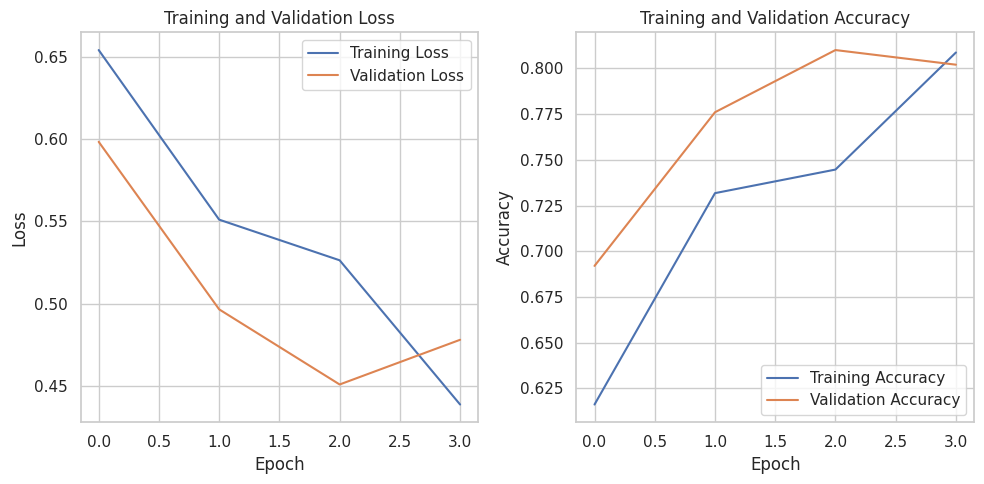

In [37]:
train_loss = history_bert.history['loss']
val_loss = history_bert.history['val_loss']
train_accuracy = history_bert.history['binary_accuracy']  
val_accuracy = history_bert.history['val_binary_accuracy']  

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [38]:
# Predict the outputs for the test set

result_bert = model.predict([test_input_ids,test_attention_masks])

32/32 [==============================] - 14s 326ms/step


In [39]:
model.save("saved_model/umberto_model1.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [40]:
threshold = 0.5 
binary_predictions = (result_bert > threshold).astype(int)

In [41]:
# Assuming `binary_predictions` is your predicted labels for the test data
predictions_df = pd.DataFrame({"id": df_test["id"], "homotransphobic": binary_predictions.flatten()})
predictions_df.to_csv("predictions.csv", sep="\t", index=False)

In [42]:
!zip -r umberto1.zip /kaggle/working/

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/predictions.csv (deflated 71%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/wordcloud_train_data.png (deflated 1%)
  adding: kaggle/working/saved_model/ (stored 0%)
  adding: kaggle/working/saved_model/umberto_model1.h5 (deflated 18%)


In [43]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load ground truth labels
gold_path = '/kaggle/input/gold-truth/HODI_2023_test_GOLD.tsv'  # Change this to the actual path of your ground truth file
data_gold = pd.read_csv(gold_path, sep='\t', converters={'id': str, 'homotransphobic': int})

# Assuming 'homotransphobic' is the column containing true labels in the gold data
y_true = data_gold['homotransphobic']

# Load model predictions
predictions_file = '/kaggle/input/predictions/matteo.alberto.run1.tsv'  # Change this to the actual path of your predictions file
predictions_df = pd.read_csv(predictions_file, sep='\t')

# Assuming 'homotransphobic' is the column containing predicted labels in the predictions file
y_pred = predictions_df['homotransphobic']

# Calculate evaluation metrics
#accuracy = accuracy_score(y_true, y_pred)
#precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

#print("Accuracy:", accuracy)
#print("Precision:", precision)
#print("Recall:", recall)
#print("F1 Score:", f1)
#print("Confusion Matrix:")
print("TN:", tn, " FP:", fp)
print("FN:", fn, " TP:", tp)

classification_rep = classification_report(y_true, y_pred)

# Print the classification report
print("Classification Report:")
print(classification_rep)

TN: 454  FP: 35
FN: 283  TP: 228
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.93      0.74       489
           1       0.87      0.45      0.59       511

    accuracy                           0.68      1000
   macro avg       0.74      0.69      0.66      1000
weighted avg       0.74      0.68      0.66      1000



/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

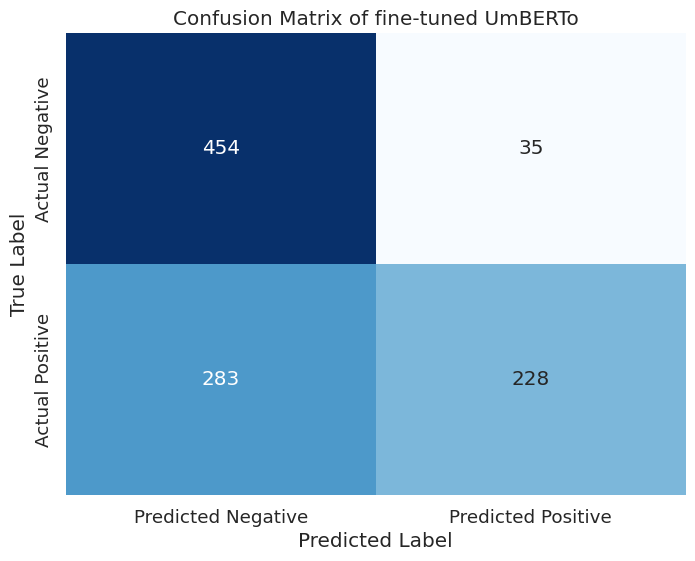

In [44]:
conf_mat = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues", cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of fine-tuned UmBERTo')
plt.show()

In [45]:
plt.savefig('saved_model/umberto_confmat.png')

<Figure size 640x480 with 0 Axes>

In [46]:
import pandas as pd
from sklearn.metrics import confusion_matrix

# Load ground truth labels
gold_path = '/kaggle/input/gold-truth/HODI_2023_test_GOLD.tsv'
data_gold = pd.read_csv(gold_path, sep='\t', converters={'id': str, 'homotransphobic': int})
y_true = data_gold['homotransphobic']

# Load model predictions
predictions_file = '/kaggle/input/predictions/matteo.alberto.run1.tsv'
predictions_df = pd.read_csv(predictions_file, sep='\t')
y_pred = predictions_df['homotransphobic']

# Get indices of False Positives and False Negatives
false_positive_indices = [i for i in range(len(y_true)) if (y_true[i] == 0 and y_pred[i] == 1)]
false_negative_indices = [i for i in range(len(y_true)) if (y_true[i] == 1 and y_pred[i] == 0)]

# Extract the original text for False Positives and False Negatives
false_positive_texts = data_gold.loc[false_positive_indices, 'text']
false_negative_texts = data_gold.loc[false_negative_indices, 'text']

# Create a DataFrame for False Positives
false_positive_df = pd.DataFrame({'Predicted Label': 1, 'Actual Label': 0, 'Text': false_positive_texts})

# Create a DataFrame for False Negatives
false_negative_df = pd.DataFrame({'Predicted Label': 0, 'Actual Label': 1, 'Text': false_negative_texts})

# Combine both DataFrames into a single DataFrame
combined_df = pd.concat([false_positive_df, false_negative_df], ignore_index=True)

# Save the combined DataFrame to a CSV file
combined_df.to_csv('false_predictions_umberto.csv', index=False)

# Model: AlBERTo
trained on Twitter data. So theoratically bettter?

In [100]:
# Load the BERT model from HuggingFace
MODEL_ALBERTO = "m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0"

tokenizer_alberto = AutoTokenizer.from_pretrained(MODEL_ALBERTO)
model_alberto = TFAutoModelForSequenceClassification.from_pretrained(MODEL_ALBERTO, num_labels=2, from_pt=True)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [101]:
df_train = pd.read_csv('/kaggle/input/input-data/HODI_2023_train_subtaskA.tsv', sep='\t')
df_test = pd.read_csv('/kaggle/input/input-data/HODI_2023_test_subtaskA.csv', sep='\t')

In [102]:
df_train["text"] = df_train["text"].apply(pre_process)
df_test["text"] = df_test["text"].apply(pre_process)

In [103]:
X = df_train["text"].values
y = df_train["homotransphobic"].values

In [104]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=48)

In [105]:
X_test = df_test['text'].values

In [106]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape, X_test.shape

((4500,), (500,), (4500,), (500,), (1000,))

In [107]:
# After pre-processing, tokenization every word in data
MAX_LEN = 161
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer_alberto.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)  # Save input_ids and attention_masks as Numpy Arrays

In [108]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [109]:
import tensorflow as tf

def create_model_with_regularization(bert_model, max_len=MAX_LEN, dropout_rate=0.3, l1=0.01, l2=0.01):
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss = tf.keras.losses.BinaryCrossentropy()
    accuracy = tf.keras.metrics.BinaryAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')

    # Use the bert_model to get the outputs
    outputs = bert_model([input_ids, attention_masks])

    # Extract the logits from TFSequenceClassifierOutput
    logits = outputs.logits

    # Apply dropout for better generalization
    dropout = tf.keras.layers.Dropout(rate=dropout_rate)(logits)

    # Modify the pooling 
    pooled = tf.reduce_mean(dropout, axis=1)
    
    # Reshape the pooled tensor to (None, 1)
    pooled = tf.keras.layers.Reshape((1,))(pooled)

    # Output layer with sigmoid activation for binary classification
    output = tf.keras.layers.Dense(1, activation="sigmoid",
                                   kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))(pooled)

    # Define the model
    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)

    # Compile the model
    model.compile(optimizer=opt, loss=loss, metrics=[accuracy])

    return model

In [110]:
model_alberto = create_model(model_alberto, MAX_LEN)
model_alberto.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 161)]                0         []                            
                                                                                                  
 input_18 (InputLayer)       [(None, 161)]                0         []                            
                                                                                                  
 tf_bert_for_sequence_class  TFSequenceClassifierOutput   1843468   ['input_17[0][0]',            
 ification_3 (TFBertForSequ  (loss=None, logits=(None,    82         'input_18[0][0]']            
 enceClassification)         2),                                                                  
                              hidden_states=None, atten                                     

In [111]:
history_alberto = model_alberto.fit([train_input_ids,train_attention_masks], # Inputs from tokenzied data for training
                                     y_train, # Labels for training
                                     validation_data=([val_input_ids,val_attention_masks], 
                                                      y_valid), # Splitting for validation data using y_Valid defined before
                                     epochs=4, batch_size=32) 

Epoch 1/4
141/141 [==============================] - 198s 1s/step - loss: 0.6815 - binary_accuracy: 0.6420 - val_loss: 0.6694 - val_binary_accuracy: 0.6920
Epoch 2/4
141/141 [==============================] - 146s 1s/step - loss: 0.6454 - binary_accuracy: 0.7873 - val_loss: 0.6369 - val_binary_accuracy: 0.7780
Epoch 3/4
141/141 [==============================] - 146s 1s/step - loss: 0.6252 - binary_accuracy: 0.8022 - val_loss: 0.6211 - val_binary_accuracy: 0.7920
Epoch 4/4
141/141 [==============================] - 146s 1s/step - loss: 0.6047 - binary_accuracy: 0.8227 - val_loss: 0.6090 - val_binary_accuracy: 0.7900


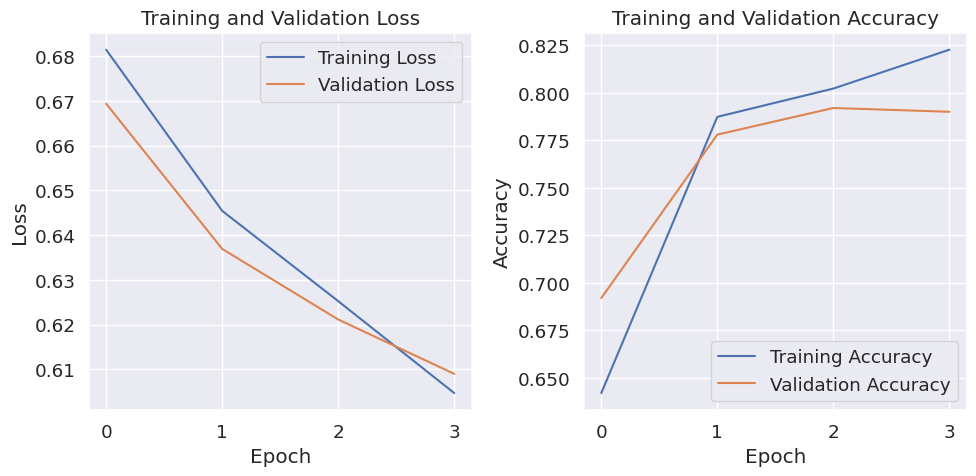

In [112]:
train_loss = history_alberto.history['loss']
val_loss = history_alberto.history['val_loss']
train_accuracy = history_alberto.history['binary_accuracy']  
val_accuracy = history_alberto.history['val_binary_accuracy']  

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [113]:
# Predict the outputs for the test set

result_alberto = model_alberto.predict([test_input_ids,test_attention_masks])

32/32 [==============================] - 14s 321ms/step


In [114]:
threshold = 0.5 
binary_predictions = (result_alberto > threshold).astype(int)

predictions_alberto_df = pd.DataFrame({"id": df_test["id"], "homotransphobic": binary_predictions.flatten()})
predictions_alberto_df.to_csv("predictions_alberto_best.tsv", sep="\t", index=False)

In [115]:
model_alberto.save("alberto_model_best.keras")

/opt/conda/lib/python3.10/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


In [116]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from lime.lime_text import LimeTextExplainer

# Load ground truth labels
gold_path = '/kaggle/input/gold-truth/HODI_2023_test_GOLD.tsv'  # Change this to the actual path of your ground truth file
data_gold = pd.read_csv(gold_path, sep='\t', converters={'id': str, 'homotransphobic': int})

# Assuming 'homotransphobic' is the column containing true labels in the gold data
y_true = data_gold['homotransphobic']

# Load model predictions
predictions_file = 'predictions_alberto_best.tsv'  # Change this to the actual path of your predictions file
predictions_df = pd.read_csv(predictions_file, sep="\t")

# Assuming 'homotransphobic' is the column containing predicted labels in the predictions file
y_pred = predictions_df['homotransphobic']

# Calculate evaluation metrics
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

print("TN:", tn, " FP:", fp)
print("FN:", fn, " TP:", tp)

# Classification Report
classification_rep = classification_report(y_true, y_pred)
print("Classification Report:")
print(classification_rep)

TN: 453  FP: 36
FN: 243  TP: 268
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.93      0.76       489
           1       0.88      0.52      0.66       511

    accuracy                           0.72      1000
   macro avg       0.77      0.73      0.71      1000
weighted avg       0.77      0.72      0.71      1000



/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

In [117]:
from lime.lime_text import LimeTextExplainer
from IPython.core.display import display, HTML
import numpy as np

def predict_proba_lime(samples):
    input_ids, attention_masks = tokenize(samples, MAX_LEN)
    predictions = model_alberto.predict([input_ids, attention_masks])
    return np.column_stack([1 - predictions, predictions])  # Stack both class probabilities

class_names = ['0', '1']
explainer = LimeTextExplainer(class_names=class_names)

def generate_lime_explanation(text_instance, instance_index, num_features=6, save_path='explanation.html'):
    explanation = explainer.explain_instance(text_instance, predict_proba_lime, num_features=num_features)
    explanation.save_to_file(save_path)
    return save_path

# Choose 10 random indices
random_indices = np.random.choice(len(X_test), 3, replace=False)

# Iterate over 10 random examples
for i, instance_index in enumerate(random_indices):
    text_instance = X_test[instance_index]
    html_path = generate_lime_explanation(text_instance, instance_index, num_features=6, save_path=f'explanation_{i}.html')
    
    # Display the HTML plot
    display(HTML(f'<iframe src={html_path} width=700 style="background: #FFFFFF;" height=350></iframe>'))

/tmp/ipykernel_47/2306419195.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


157/157 [==============================] - 54s 341ms/step


/opt/conda/lib/python3.10/site-packages/IPython/core/display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


157/157 [==============================] - 55s 353ms/step


/opt/conda/lib/python3.10/site-packages/IPython/core/display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


157/157 [==============================] - 55s 350ms/step


/opt/conda/lib/python3.10/site-packages/IPython/core/display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [118]:
from IPython.core.display import display, HTML
display(HTML('<iframe src=explanation.html width=700 style="background: #FFFFFF;" height=350></iframe'))

/tmp/ipykernel_47/2753398111.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

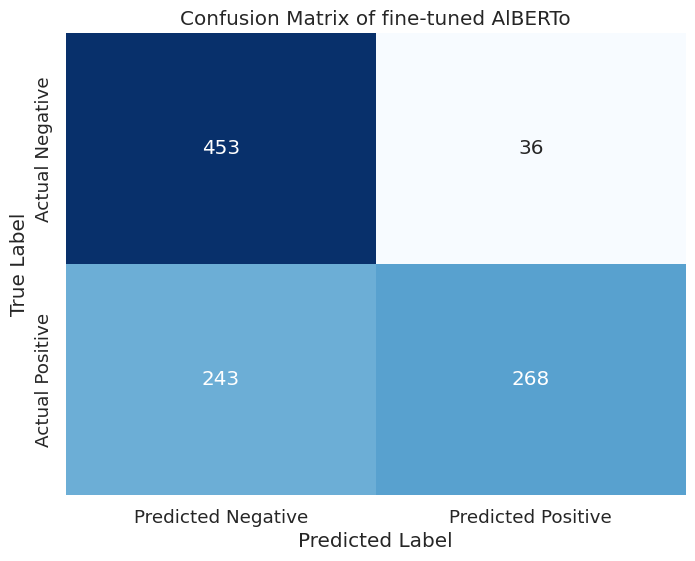

In [119]:
conf_mat = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues", cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of fine-tuned AlBERTo')
plt.savefig('alberto_confmat_last.png')
plt.show()

In [ ]:
!zip -r file.zip /kaggle/working

# Explainability with SHAP

In [ ]:
from lime.lime_text import LimeTextExplainer
from tqdm import tqdm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

# Function to predict probabilities using the BERT model
def predict_proba(text_arr):
    input_ids, attention_masks = tokenize(text_arr, MAX_LEN)
    pred = model_alberto.predict([input_ids, attention_masks])
    return pred  # Assuming pred is a 2D array with probabilities for both classes

# Function to transform the input for LIME
def text_transformer(text_arr):
    return text_arr

# Create a pipeline for LIME
lime_pipeline = make_pipeline(FunctionTransformer(text_transformer, validate=False), model_alberto)

# Initialize LimeTextExplainer
explainer = LimeTextExplainer(class_names=['0', '1'])

# Choose an example from your dataset for explanation
example_index = 4
example_text = X_test[example_index]

# Explain the instance
explanation = explainer.explain_instance(example_text, predict_proba, num_features=10)

# Visualize the explanation
explanation.show_in_notebook(text=True)

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_t5 = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-large")

tokenizer_t5 = AutoTokenizer.from_pretrained("google/flan-t5-large")

In [ ]:
model_t5.train(
